# Exercise: Vision Transformers

In this exercise session, we will learn about **Vision Transformers**. The Transformer architecture initially emerged in natural language processing as a solution for processing long texts by capturing long-range dependencies. For instance, this is the typical architecture used by Large Language Models like GPT or Gemini. The Vision Transformer, on the other hand, is a variant of the Transformer tailored to process images instead of sequence-like data. While Vision Transformers can outperform CNN architectures on many benchmarks, they may underperform if the amount of data used during training is insufficient.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST

In [2]:
%load_ext autoreload
%autoreload 2

Just like in previous weeks, we will once again be working with the MNIST dataset:

In [3]:
batch_size = 128

# Dataset and DataLoader
dataset_train = MNIST('data', train=True, download=True, transform=ToTensor())
dataset_test = MNIST('data', train=False, download=True, transform=ToTensor())
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print('Loaded {} train and {} valid samples.'.format(len(dataset_train), len(dataset_test)))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 7.44MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 96.8kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.58MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 5.44MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Loaded 60000 train and 10000 valid samples.


# Vision Transformer (ViT)

The orignal version of the Vision Transformer (ViT) was introduced in the seminal paper of [Dosovitskiy et al., 2020](https://arxiv.org/abs/2010.11929). It adapts the Transformer architecture to process images for tasks such as image classification. Specifically, it replaces the traditional convolutional layers with self-attention mechanisms, enabling it to capture global dependencies within the image. To accommodate image processing, several additional modules are integrated. Here is an overview ([Bazi et al., 2021](https://www.researchgate.net/publication/348947034_Vision_Transformers_for_Remote_Sensing_Image_Classification)) of the various components of this architecture:

![ViT Overview](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)

In this exercise, we will cover each of these modules individually to gain a comprehensive understanding of the entire architecture. Don't hesitate to come back to this figure.

## Patchification

The Transformer architecture operates by treating tokens as input. In textual contexts, each token typically represents either a word or a subword unit. However, in a visual context, tokens are essentially patches extracted from the images. Therefore, the initial step involves dividing the image into several patches of equal size.
In the case of the MNIST dataset, we divide the 28x28 images into 7x7 grids, resulting in 49 patches, each measuring 4x4 pixels. It's important to note that since we're working with black-and-white images, there's only a single channel. Following this division, each patch undergoes individual linear projection.

![Patchification](https://miro.medium.com/v2/resize:fit:822/format:webp/1*CFbOxEuvo-Pgq7ETIrt0Eg.png)


Write the code to generate a list of patches for a given set of images. `n_patches` represents the number of patches in a row, set to 7 in this case.

In [10]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w # We assume square image.

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for img_idx in range(n): # for each image
        patch_idx = 0
        for i in range(0, h, patch_size): # on parcourt chaque ligne en ajoutant à chaque fois la taille d'un patch
            for j in range(0, w, patch_size): # et chaque colonne, pareil avec la taille d'un patch
                patch = images[img_idx, :, i:i+patch_size, j:j+patch_size]  # (c, patch_size, patch_size)
                patches[img_idx, patch_idx] = patch.flatten()
                patch_idx += 1
    return patches


assert patchify(torch.rand(2, 1, 28, 28), 2).shape == (2, 4, 196)
assert patchify(torch.rand(16, 3, 56, 56), 7).shape == (16, 49, 192)

## Positional encoding

The positional encoding brings order to the tokens. Without the position token, we do not know where in the image is a particular token from. While there are many different ways to learn the positional encoding, we refer to the earliest implementationm, which used sinusoidals to encode the location.

$\text{positional\_encoding}(i, 2j) = \sin\left(\frac{i}{10000^{2j / d_{\text{model}}}}\right)$
$\text{positional\_encoding}(i, 2j+1) = \cos\left(\frac{i}{10000^{2j / d_{\text{model}}}}\right)$


In [27]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d // 2):
            angle = i / (10000 ** (2 * j / d))
            result[i, 2 * j] = torch.sin(torch.tensor(angle))
            result[i, 2 * j + 1] = torch.cos(torch.tensor(angle))
    return result

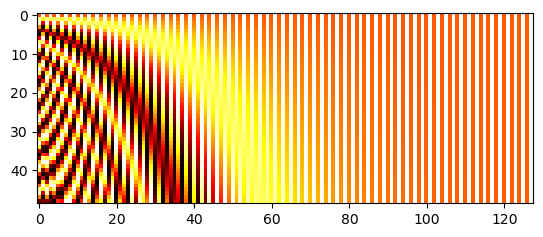

In [28]:
plt.imshow(get_positional_embeddings(49, 128).numpy(), cmap="hot", interpolation="nearest")
plt.show()

## Multi-head Self-attention

The major component in the transformer is the unit of multi-head self-attention mechanism. The transformer views the encoded representation of the input as a set of **key-value** pairs, (**K, V**), both of dimension *n*. The transformer adopts the scaled dot-product attention: the output is a weighted sum of the values, where the weight assigned to each value is determined by the dot-product of the query with all the keys:


Attention(Q, K, V) = Softmax$\dfrac{QK^T}{\sqrt{n}}V$

With multi-head self attention, we repeat the attention module multiple times in parallel with the same Q,K,V triplet. The independent attention outputs are simply concatenated and linearly transformed into the expected dimensions. I assume the motivation is because ensembling always helps? ;) According to the paper, “multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.

![https://lilianweng.github.io/posts/2018-06-24-attention/multi-head-attention.png](https://lilianweng.github.io/posts/2018-06-24-attention/multi-head-attention.png)

In [32]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"
        d_head = int(d / n_heads)
        self.d_head = d_head

        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):

                # Select the mapping associated to the given head.
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]

                # Map seq to q, k, v.
                Q = q_mapping(seq)  # (seq_len, d_head)
                K = k_mapping(seq)  # (seq_len, d_head)
                V = v_mapping(seq)  # (seq_len, d_head)

                attention = self.softmax((Q @ torch.tranpose(K))/(torch.sqrt(torch.tensor(self.d_head, dtype=torch.float32)))) * V
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

## Vit Block

LayerNorm is a kind of normalization layer which normalizes across all features for a single element in a batch. Given an input, LayerNorm scales the features by subtracting the mean and dividing by the standard deviation.

LayerNorm differs from BatchNorm is the way the statistics are computed. Why BatchNorm scales each feature by computing its statistics across the batch, LayerNorm scales features by computing its statistics across all features for a given element in a batch.

More information about various normalisation layers: [YouTube, Yannic Kilcher](https://www.youtube.com/watch?v=l_3zj6HeWUE)


![Examples of different normalizations](https://miro.medium.com/v2/resize:fit:656/format:webp/1*xf37Ts0mdBGiS-keOwviOQ.png)

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = ### WRITE YOUR CODE HERE using LayerNorm pytorch
        self.mhsa = MyMSA(hidden_d, n_heads) ### WRITE YOUR CODE HERE
        self.norm2 =### WRITE YOUR CODE HERE using LayerNorm pytorch
        self.mlp = nn.Sequential( ### WRITE YOUR CODE HERE
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        # Write code for MHSA + residual connection.
        out = #
        # Write code for MLP(Norm(out)) + residual connection
        out = #
        return out

## ViT model

Now we can put all together:

In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        super(MyViT, self).__init__()

        self.chw = chw # (C, H, W)
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0 # Input shape must be divisible by number of patches
        assert chw[2] % n_patches == 0
        self.patch_size =  ### WRITE YOUR CODE HERE patch size in terms of height and width

        # Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # Positional embedding
        # HINT: don't forget the classification token
        self.positional_embeddings =  ### WRITE YOUR CODE HERE

        # Transformer blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):

        n, c, h, w = images.shape

        # Divide images into patches.
        patches = ### WRITE YOUR CODE HERE

        # Map the vector corresponding to each patch to the hidden size dimension.
        tokens = self.linear_mapper(patches)

        # Add classification token to the tokens.
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Add positional embedding.
        # HINT: use torch.Tensor.repeat(...)
        out = ### WRITE YOUR CODE HERE

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Get the classification token only.
        out = out[:, 0]

        # Map to the output distribution.
        out = self.mlp(out)

        return out

In [ ]:
chw = (1, 28, 28)
n_patches = 7
n_blocks = 2
n_blocks = 2
hidden_d = 8
n_heads = 2
out_d = 10
model = MyViT(chw = (1, 28, 28), n_patches=n_patches, n_blocks=n_blocks,
              hidden_d=hidden_d, n_heads=n_heads, out_d=out_d)

In [ ]:
def accuracy(x, y):
    x = x.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    return np.mean(np.argmax(x, axis=1) == y)

Now you can reuse the code of last week exercise, since the only difference is the architecture. The training procedure is the same.

In [ ]:
epochs = 20

learning_rate = 0.005
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()

In [ ]:
def train_model(model, criterion, optimizer, dataloader_train, dataloader_test, epochs):
    """ Trains the model for the specified number of epochs on the dataset.

    Args:
        model: The model to train.
        criterion: The loss function.
        optimizer: The optimizer to use.
        dataloader_train: The DataLoader for the training set.
        dataloader_test: The DataLoader for the test set.
        epochs: The number of epochs to train for.
    """
    for ep in range(epochs):
        train_loss = 0.0
        for it, batch in enumerate(dataloader_train):

            # Load a batch, break it down in images and targets.
            x, y = batch

            # Run forward pass.
            logits = model(x)

            # Compute loss (using 'criterion').
            loss = criterion(logits, y)

            # Run backward pass.
            loss.backward()

            train_loss += loss.detach().cpu().item() / len(dataloader_train)

            # Update the weights using 'optimizer'.
            optimizer.step()

            # Zero-out the accumulated gradients.
            optimizer.zero_grad()

            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}, accuracy train: {:.2f}'.
                          format(ep + 1, epochs, it + 1, len(dataloader_train), loss,
                                accuracy(logits, y)), end='')

        # Validation.
        model.eval()
        with torch.no_grad():
            acc_run = 0
            for it, batch in enumerate(dataloader_test):
                # Get batch of data.
                x, y = batch
                curr_bs = x.shape[0]
                acc_run += accuracy(model(x), y) * curr_bs
            acc = acc_run / len(dataloader_test.dataset)

            print(', accuracy test: {:.2f}'.format(acc))

In [ ]:
train_model(model, criterion, optimizer, dataloader_train, dataloader_test, epochs)

How does it compare with the previous project on CNNs?

In general Transformers are shown to be effective since they leverage large models with a higher parameter count more effectively than the convolutional architectures. However, the performance gains of transformers may not necessarily replicate when comparing against a small convolutional model. Moreover, this is still an active direction of research, with ConvNext and hybrid approaches claiming at par performance with Transformers.

Can you think of different hyperparameters to improve model performance?
How would the performance change by modifying the number of heads in multi-head attention? How would performance change by altering the number of patches? Did you try alternate positional encoding techniques?

Feel free to tinker with this code!

These coding exercises were inspired by this [blog post](https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c).